# CROC-CARIB12-Default -> Full Resolution Bathymetry
## Regional CESM-MOM6 for Caribbean with Default CrocoDash Grids and Inputs

This notebook is working off of a basic version of CARIB12 (Seijo-Ellis et al. 2024). The goal of this first test is to run the same domain over a short time period from January 1st, 2000 to January 5th, 2000 and compare with CARIB12. We are using the same grids and resolution, but the topography, CESM version, and tidal data are the different. This also uses the built in CrocoDash feature to generate a custom script to fetch glorys data using the copernicusmarine CLI; this should be the same as Gio's data (need to verify).

## Generate Regional MOM6 Domain

### Horizontal Grid

In [1]:
from CrocoDash.grid import Grid

grid = Grid(
    resolution=1/12, # 1/12 deg resolution (hopefully fraction doesn't cause an issue)
    xstart=261.5, # 261.5° E or 98.5° W 
    lenx=63, # 35.5° W
    ystart=-6, # 6° S
    leny=38, # 32° N
    name='CrocCaribDefault'
)

## Bathymetry
The Full GEBCO Data is so large that it needs to be processed in parallel using mpi

In [2]:
## Manually added a method `setup_bathymetry_mpi` to topo.py and added some optional args to rmom6 `setup_bathymetry()` accordingly
from CrocoDash.topo import Topo

topo = Topo(
    grid = grid,
    min_depth = 9.5,
)

bathymetry_path = '/glade/work/ajanney/CrocoDashData/inputs/bathymetry/GEBCO_2024.nc'

expt = topo.setup_bathymetry_mpi(
        file_path=bathymetry_path,
        longitude_coordinate_name='lon',
        latitude_coordinate_name='lat',
        vertical_coordinate_name='elevation',
        temp_bathy_directory='/glade/work/ajanney/CaribCrocoDash/CaribCrocoData', ## Probably need to add a default make dir to this just to be safe
        fill_channels=False,
        positive_down=False
    )

You opted for manual interpolation of bathymetry. This is often necessary
When the domain is large or the bathymetry is very high resolution.

The unfinished bathymetry file can be found at /glade/work/ajanney/CaribCrocoDash/CaribCrocoData/bathymetry_unfinished.nc.
We reccomend opening a terminal with the appropriate comutational resources and call ESMF regrdiing tools with mpirun
`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.





In [5]:
bathy = expt.tidy_bathymetry(
            write_to_file=True,
        )

topo._depth = bathy.depth

Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in inland lakes and channels... 

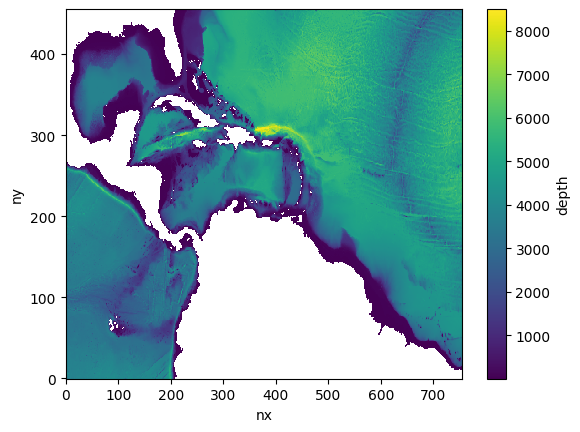

In [6]:
topo.depth.plot()

In [ ]:
'''
## After already interpolating, more efficient to just load it in
topo = Topo.from_topo_file(
    grid = grid,
    topo_file_path='/glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/ocnice/ocean_topog_CrocCaribDefault_4c66c5.nc',
    min_depth=10 # meters
    )
'''

In [7]:
# Erase Pacific & Canada Bays
%matplotlib ipympl

from CrocoDash.topo_editor import TopoEditor
topo.depth["units"] = "m"
TopoEditor(topo)

TopoEditor(children=(VBox(children=(HTML(value='<h2>Topo Editor</h2>'), HTML(value='<hr><h3>Display</h3>'), To…

<Figure size 1280x960 with 0 Axes>

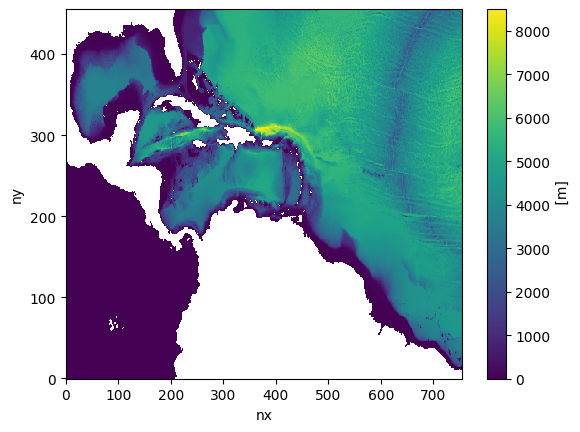

In [8]:
## Check bathymetry again after edits
import matplotlib.pyplot as plt

%matplotlib inline
plt.clf()
plt.figure()
topo.depth.plot()

## Vertical Grid

In [9]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 65,
    depth = topo.max_depth,
    ratio=99.48 # from Gio's paper 248.7/2.5=99.48
)

[  3.07896354   3.18232925   3.30800769   3.46078574   3.64646302
   3.87205943   4.14606189   4.47871626   4.88237017   5.37187247
   5.96503331   6.68314662   7.55157222   8.60036771   9.86494937
  11.38674566  13.21378442  15.40112607  18.01101753  21.11259887
  24.78094935  29.09522244  34.13560483  39.97886715  46.69238085
  54.32668581  62.90701773  72.4246217   82.82911198  94.02344985
 105.86312853 118.1607324  130.69615449 143.23157658 155.52918046
 167.36885914 178.56319701 188.96768728 198.48529126 207.06562318
 214.69992814 221.41344184 227.25670416 232.29708655 236.61135963
 240.27971012 243.38129146 245.99118292 248.17852457 250.00556333
 251.52735961 252.79194128 253.84073676 254.70916236 255.42727568
 256.02043652 256.50993882 256.91359273 257.2462471  257.52024956
 257.74584597 257.93152325 258.0843013  258.20997974 258.31334545]


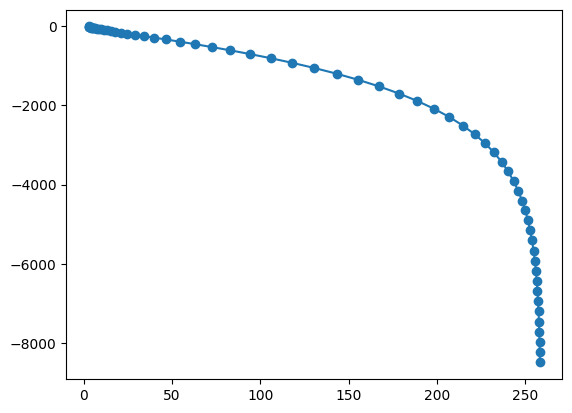

In [10]:
import numpy as np
print(vgrid.dz)
plt.plot(vgrid.dz,-np.cumsum(vgrid.dz),'o-')

## Creating the CESM Case

In [11]:
from pathlib import Path

# CESM case (experiment) name
casename = "CrocCaribDefault"

# CESM source root (Update this path accordingly!!!)
cesmroot = '/glade/work/ajanney/CESM-versions/CROC_CESM' # Path.home() / "cesm3_0_beta04"
# I grabbed this version from Alper

# Place where all your input files go 
inputdir = Path("/glade/work/ajanney/CrocoDash_Input",casename) # Path.home() / "croc_input" / casename
    
# CESM case directory
caseroot = Path("/glade/work/ajanney/CESM/cases",casename) # Path.home() / "croc_cases" / casename

In [12]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'P93300012', # also can be unspecified if set by user config e.g. export PBS_ACCOUNT=P93300012
    override = True,
)

INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "CrocCaribDefault" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "CrocCaribDefault".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "CrocCaribDefault" with the following properties:
 nx: 756, ny: 456. ocean mesh: /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault/ocnice/ESMF_mesh_CrocCaribDefault_9419eb.nc.

Running the create_newcase tool with the following command:

/glade/work/ajanney/CESM-versions/CROC_CESM/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res CrocCaribDefault --case /glade/work/ajanney/CESM/cases/CrocCaribDefault --machine derecho --run-unsupported --project P93300012 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/work/ajanney/CESM/cases/CrocCaribDefault

Apply NTASK grid xml changes:

./xmlch

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/work/ajanney/CESM/cases/CrocCaribDefault.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



## Ocean Forcing Data from Glorys

In [13]:
start_date_iter = "2000-01-01 00:00:00"
end_date_iter = "2020-01-05 00:00:00"

case.configure_forcings(
    date_range = [start_date_iter, end_date_iter],
    tidal_constituents = ['M2', 'S2', 'N2', 'K2', 'K1', 'O1', 'P1', 'Q1', 'MM', 'MF'],
    tpxo_elevation_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/h_tpxo9.v1.nc", 
    # original: "/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/h_tpxo9.v1.nc",
    tpxo_velocity_filepath = "/glade/work/ajanney/CrocoDashData/inputs/tidal_data/u_tpxo9.v1.nc" 
    # original: "/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/u_tpxo9.v1.nc"
)

INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/derecho/scratch/ajanney/tmp/tmp03vngb7u/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data access method retuns a script at path /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault/glorys/get_glorys_data.sh to run to get access data 
INFO:CrocoDash.data_access.glorys:This data access method retuns a script

This domain is too big, so we use Manish's latest cool tool the Data Access module instead, this will generate a script for retrieving the data either from the RDA or through a PBS script (I think, it may always be through the RDA)

In [ ]:
from CrocoDash.data_access import glorys as gl
from CrocoDash.data_access import driver as dv
import xarray as xr

raw_data_sub_folder = '/glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/glorys_raw'

hgrid = xr.open_dataset(
"/glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/ocnice/ocean_hgrid_CrocCaribDefault_7728f2.nc"
)
bounds = dv.get_rectangular_segment_info(hgrid)
key = "ic" # or east, north, west, south, ic
gl.get_glorys_data_from_rda([start_date_iter,end_date_iter], bounds[key]["lat_min"], bounds[key]["lat_max"], bounds[key]["lon_min"], bounds[key]["lon_max"], output_dir = raw_data_sub_folder, output_file = key+"_unprocessed.nc")

INFO:CrocoDash.data_access.glorys:Downloading Glorys data from RDA to /glade/work/ajanney/CrocoDash_Input/CrocCaribDefault_Coarse/glorys_raw/ic_unprocessed.nc


In [14]:
case.process_forcings(
    process_velocity_tracers=False # already done manually
    )

INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder


Setting up Initial Conditions
Regridding Velocities... 

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Getting u points..
INFO:regional_mom6.regridding:Getting v points..


Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.


INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder


Processing south boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_001
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_001
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing north boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_002
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_002
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing west boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_003
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_003
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Processing east boundary...

INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Adding perpendicular dimension to zamp_segment_004
INFO:regional_mom6.regridding:Adding perpendicular dimension to zphase_segment_004
INFO:regional_mom6.regridding:Generating encoding dictionary
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.rotation:Getting rotat

Done
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = init_vel.nc

  ! Tides
  TIDES = True
  TIDE_M2 = True
  CD_TIDES = 0.0018
  TIDE_USE_EQ_PHASE = True
  TIDE_REF_DATE = 2000, 1, 1
  OBC_TIDE_ADD_EQ_PHASE = True
  OBC_TIDE_N_CONSTITUENTS = 10
  OBC_TIDE_CONSTITUENTS = "M2, S2, N2, K2, K1, O1, P1, Q1, MM, MF"
  OBC_TIDE_REF_DATE = 2000, 1, 1

  ! Open boundary conditions
  OBC_NUMBER_OF_SEGMENTS = 4
  OBC_FREESLIP_VORTICITY = False
  OBC_FREESLIP_STRAIN = False
  OBC_COMPUTED_VORTICITY = True
  OBC_COMPUTED_STRAIN = True
  OBC_ZERO_BIHARMONIC = True
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_OUT = 3.0E+04
  OBC_TRACER_RESERVOIR_LENGTH_SCALE_IN = 3000.0
